In [90]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pandas_datareader.data import DataReader
from datetime import datetime
import seaborn as sns

In [91]:
# Timeframe

end = datetime.now()
start = datetime(end.year,end.month-2,end.day)

In [92]:
stocks_df = DataReader('TSLA','robinhood',start,end)

In [93]:
len(stocks_df)

249

In [94]:
stocks_df.head()

close_price high_price  interpolated low_price open_price  \
symbol begins_at                                                              
TSLA   2017-04-17    301.4400   304.0000         False  298.6800   302.7000   
       2017-04-18    300.2500   300.8399         False  297.9000   299.7000   
       2017-04-19    305.5200   306.6200         False  302.1100   302.4600   
       2017-04-20    302.5100   309.1500         False  300.2300   306.5100   
       2017-04-21    305.6000   306.4000         False  300.4200   302.0000   

                  session   volume  
symbol begins_at                    
TSLA   2017-04-17     reg  4138736  
       2017-04-18     reg  3035698  
       2017-04-19     reg  3898024  
       2017-04-20     reg  6149352  
       2017-04-21     reg  4509756

In [97]:
stocks_df.reset_index(level=0, inplace=True)
stocks_df = stocks_df.sort_values(by='begins_at')
stocks_df = stocks_df.set_index('begins_at')
stocks_df = stocks_df.drop('index',axis=1)
stocks_df.head(1)

,symbol,close_price,high_price,interpolated,low_price,open_price,session,volume
begins_at,,,,,,,,
2017-04-17,TSLA,301.4400,304.0000,False,298.6800,302.7000,reg,4138736


### Changing the data types

In [98]:
for col in ['close_price','high_price','low_price','open_price']:
    stocks_df[col] = pd.to_numeric(stocks_df[col])
    
stocks_df.dtypes

symbol           object
close_price     float64
high_price      float64
interpolated       bool
low_price       float64
open_price      float64
session          object
volume            int64
dtype: object

### Close

Closing Prices are non-stationary.

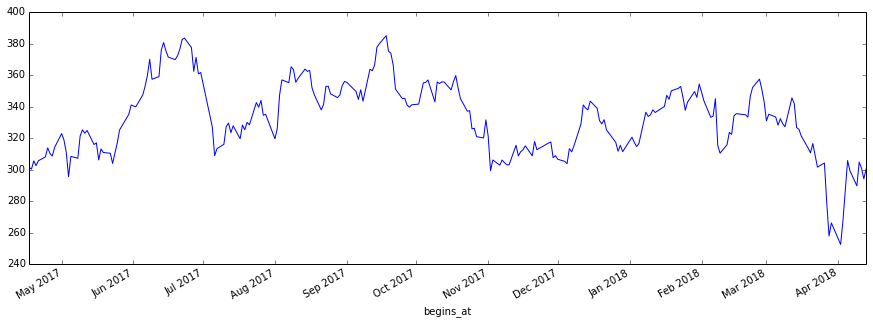

In [99]:
stocks_df['close_price'].plot(figsize=(15,5))

### First Difference

We can consider analyzing a first difference of the series. value of (t-1) is subtracted from value of (t).

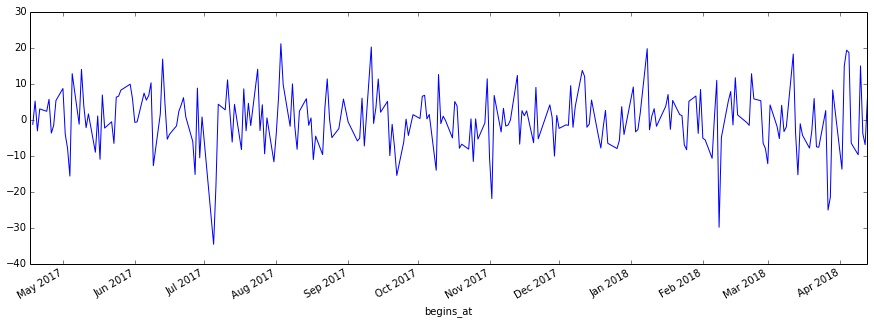

In [100]:
stocks_df['First_Difference'] = stocks_df['close_price'] - stocks_df['close_price'].shift()
stocks_df['First_Difference'].plot(figsize=(15,5))

First difference is relatively stationary and mostly fluctuates around 0. But variance of this series can vary over time. We need to incorporate mechanism to accomodate for sensing smaller variances along with the larger ones. Hence, Log.

### Log

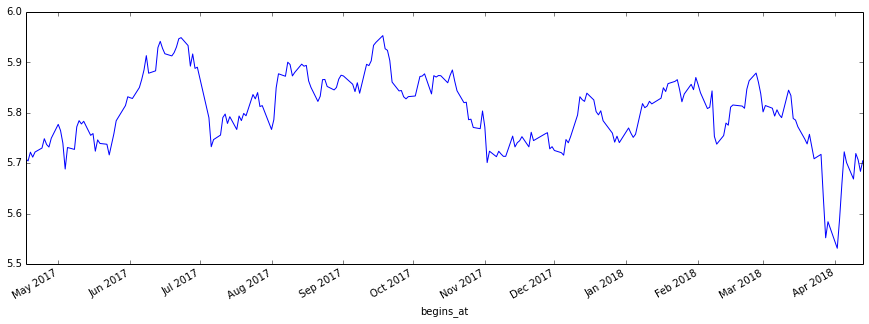

In [101]:
stocks_df['Natural_Log'] = stocks_df['close_price'].apply(lambda x: np.log(x))
stocks_df['Natural_Log'].plot(figsize=(15,5))

So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve. One way to visually see the effect that the log transform had is to analyze the variance over time. We can use a rolling variance statistic and compare both the original series and the logged series.

### Variance - with and without Log

In [102]:
#Original Rolling Variance
stocks_df['Original_Rolling_Variance'] = stocks_df['close_price'].rolling(window = 30, min_periods=None, freq=None, center=True).var()

#Log Rolling Variance
stocks_df['Log_Rolling_Variance'] = stocks_df['Natural_Log'].rolling(window = 30, min_periods=None, freq=None, center=True).var()

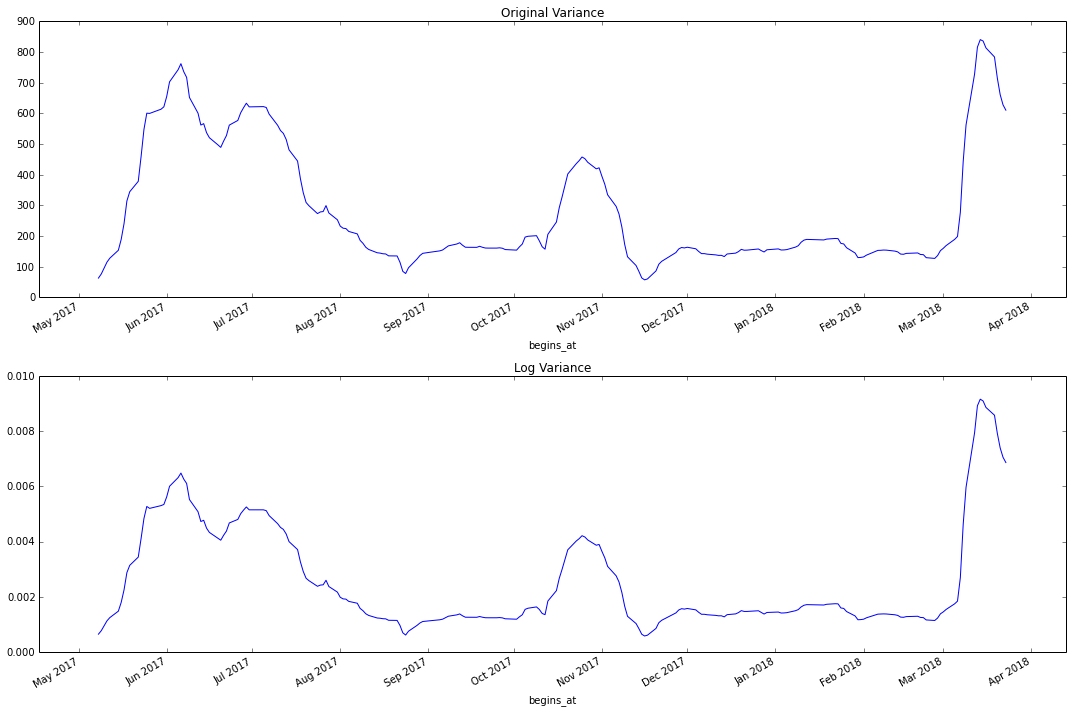

In [103]:
fig, ax = plt.subplots(2,1, figsize = (15,10))
stocks_df['Original_Rolling_Variance'].plot(ax=ax[0],title='Original Variance')
stocks_df['Log_Rolling_Variance'].plot(ax=ax[1],title='Log Variance')
fig.tight_layout()

### Normal and Logged First Difference

In [104]:
#Original Rolling Variance
#stocks_df['First_Difference']

#Log Rolling Variance
stocks_df['Log_First_Difference'] = stocks_df['Natural_Log'] - stocks_df['Natural_Log'].shift()

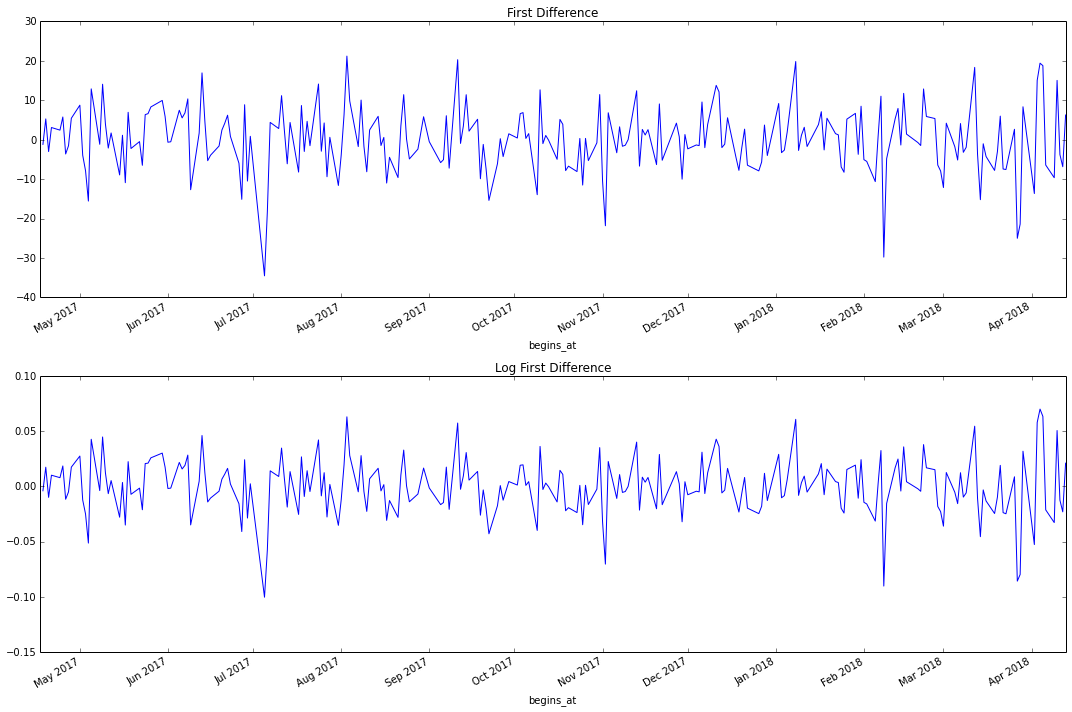

In [105]:
fig, ax = plt.subplots(2,1, figsize = (15,10))
stocks_df['First_Difference'].plot(ax=ax[0],title='First Difference')
stocks_df['Log_First_Difference'].plot(ax=ax[1],title='Log First Difference')
fig.tight_layout()

### Create a few more lag variables

In [106]:
stocks_df['Lag_1'] = stocks_df['Log_First_Difference'].shift()
stocks_df['Lag_2'] = stocks_df['Log_First_Difference'].shift(2)
stocks_df['Lag_5'] = stocks_df['Log_First_Difference'].shift(5)
stocks_df['Lag_30'] = stocks_df['Log_First_Difference'].shift(30)

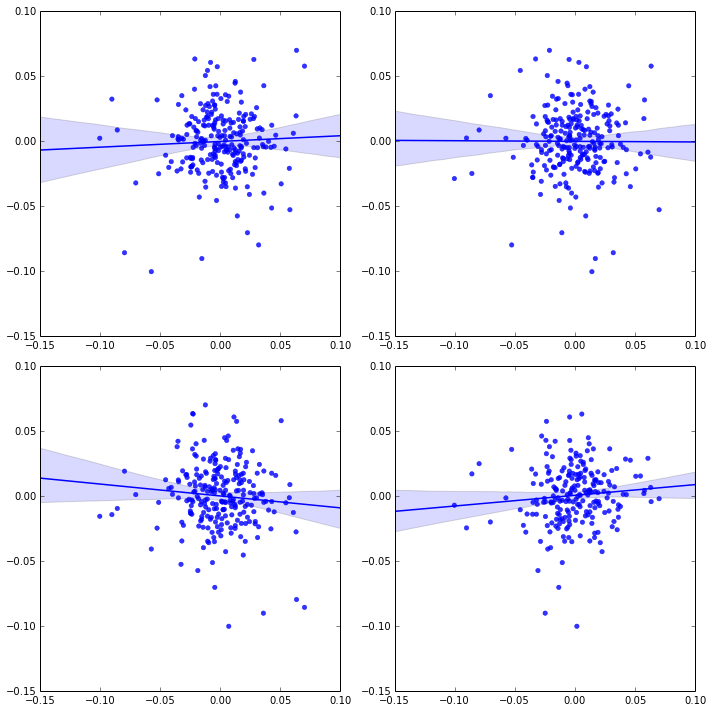

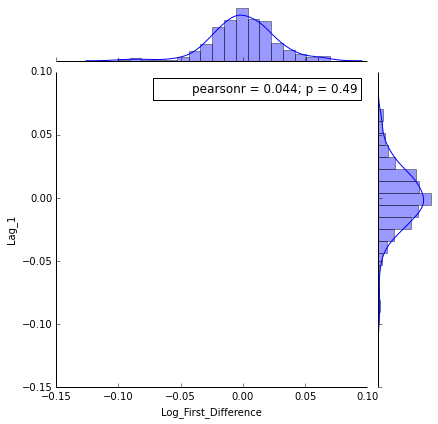

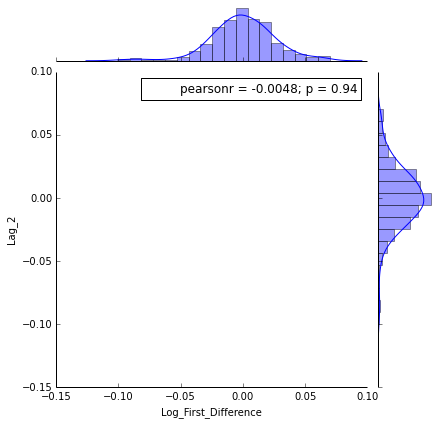

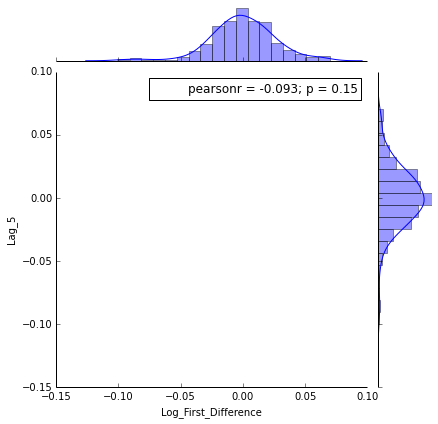

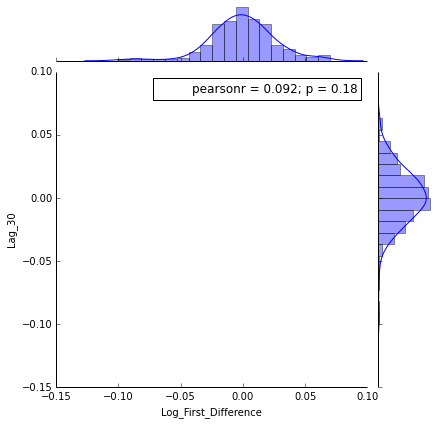

In [107]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
sns.jointplot('Log_First_Difference','Lag_1', stocks_df,kind = 'reg',ax=ax[0,0])
sns.jointplot('Log_First_Difference','Lag_2',stocks_df,kind = 'reg',ax=ax[0,1])
sns.jointplot('Log_First_Difference','Lag_5',stocks_df,kind = 'reg',ax=ax[1,0])
sns.jointplot('Log_First_Difference','Lag_30',stocks_df,kind = 'reg',ax=ax[1,1])
fig.tight_layout()

#### No apparent Correlation. It means that today's index values does not tell much about at least a few days in the future.

### Lag relationships

There could be relation in the values we did not try. There is a function to test those relationships. Let's try those.

In [108]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

In [109]:
lag_correlations = acf(stocks_df['Log_First_Difference'].iloc[1:].values)
#lag_correlations is an array
lag_partial_correlations = pacf(stocks_df['Log_First_Difference'].iloc[1:].values)
#Array as well

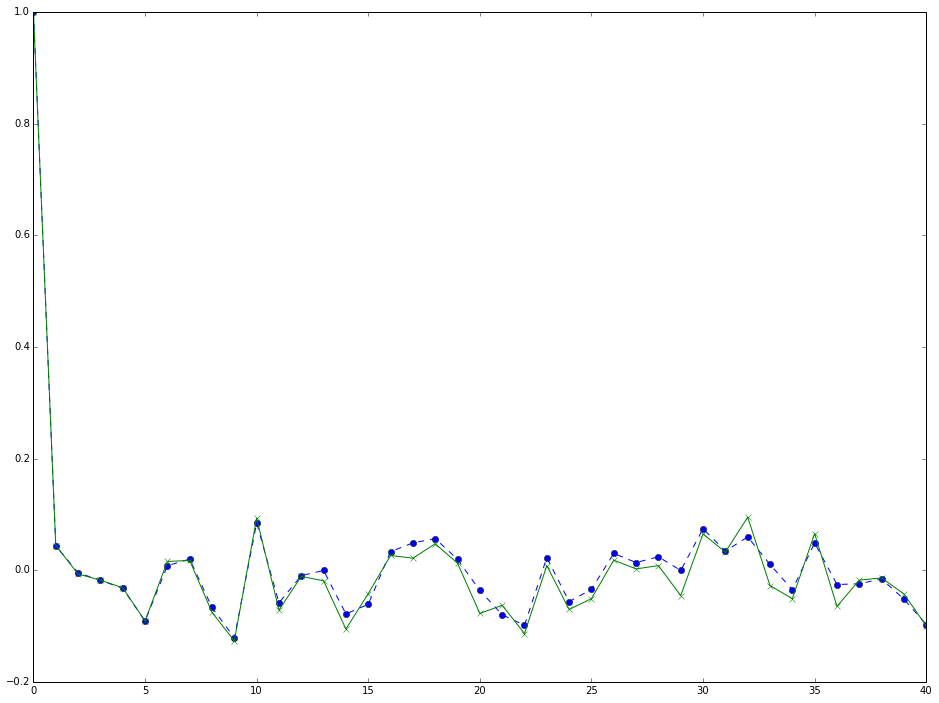

In [110]:
fig, ax = plt.subplots(figsize=(16,12))  
ax.plot(lag_correlations, marker='o', linestyle='--')
ax.plot(lag_partial_correlations, marker='x')

No apparent correlation, this is a random walk

### Seasonal Decomposition

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose  

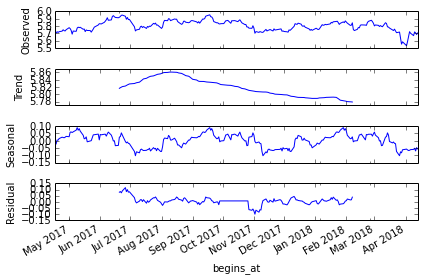

In [112]:
decomposition = seasonal_decompose(stocks_df['Natural_Log'], model='additive', freq=90)  
fig = plt.figure()  
fig = decomposition.plot()  

### ARIMA

Let's try fitting simple average model

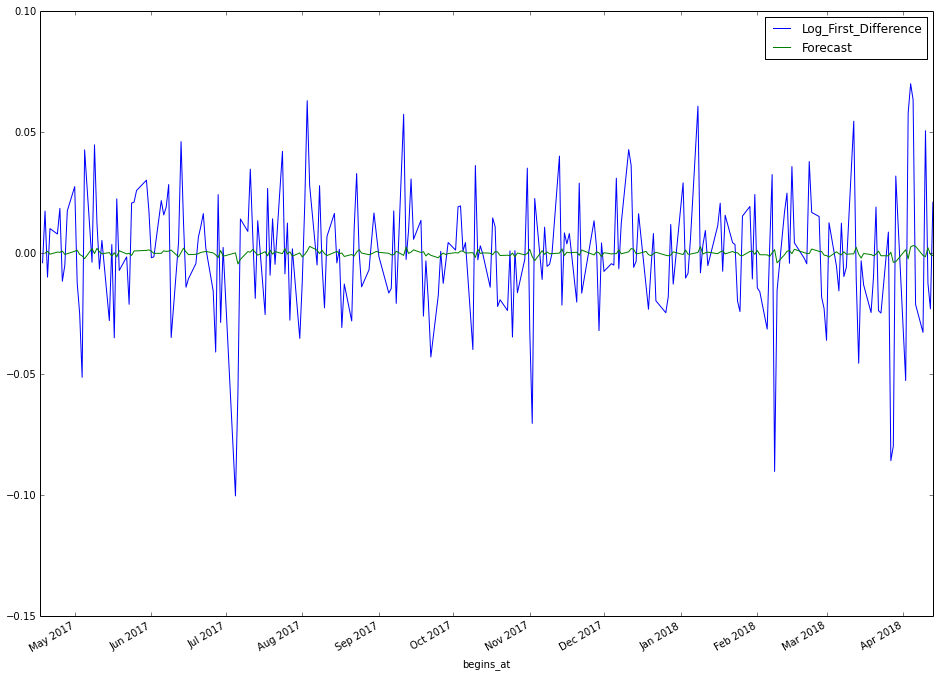

In [113]:
import statsmodels.api as sm  
model = sm.tsa.ARIMA(stocks_df['Natural_Log'].iloc[1:], order=(1, 1, 0))  
results = model.fit(disp=-1)
stocks_df['Forecast'] = results.fittedvalues
stocks_df[['Log_First_Difference','Forecast']].plot(figsize=(16,12))

This is not a good fit. Let's look at the subset

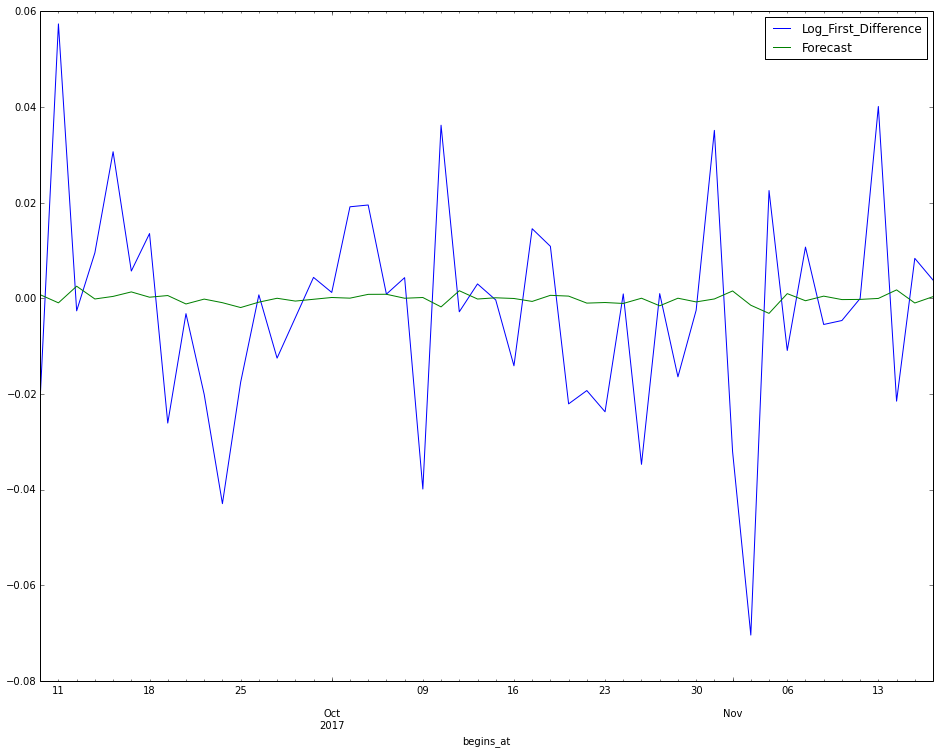

In [114]:
stocks_df[['Log_First_Difference','Forecast']].iloc[100:150, :].plot(figsize=(16,12))

#### Let's try exponential

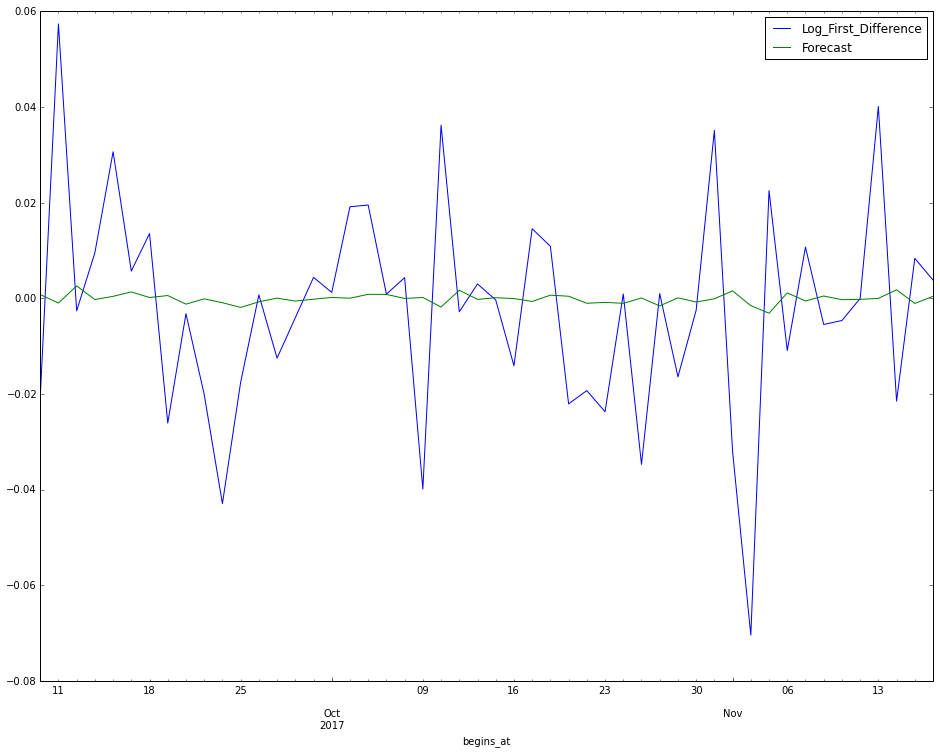

In [116]:
model = sm.tsa.ARIMA(stocks_df['Natural_Log'].iloc[1:], order=(0, 1, 1))  
results = model.fit(disp=-1)
stocks_df['Forecast'] = results.fittedvalues
stocks_df[['Log_First_Difference','Forecast']].iloc[100:150,:].plot(figsize=(16,12))